In [1]:
import netrd
import networkx as nx
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_data(w,l,binary=True):
    """
    generate binary time-series 
    - input: interaction matrix w[n,n], interaction variance g, data length l
    - output: time series s[l,n]
    """ 
    n = np.shape(w)[0]
    s = np.ones((l,n))
    for t in range(1,l-1):
        h = np.sum(w[:,:]*s[t,:],axis=1) # Wij from j to i
        p = 1/(1+np.exp(-2*h))
        if binary:
            s[t+1,:]= sign_vec(p-np.random.rand(n))
        else:
            s[t+1,:]= p-np.random.rand(n)
    return s

def sign(x):
    """
    np.sign(0) = 0 but here to avoid value 0, 
    we redefine it as def sign(0) = 1
    """
    return 1. if x >= 0 else -1.

def sign_vec(x):
    x_vec = np.vectorize(sign)
    return x_vec(x)

def cross_cov(a,b):
    """ 
    cross_covariance
    a,b -->  <(a - <a>)(b - <b>)>  (axis=0) 
    """    
    da = a - np.mean(a, axis=0)
    db = b - np.mean(b, axis=0)
    return np.matmul(da.T,db)/a.shape[0]

def get_Wout_full(G, p0=np.exp(-30)):
    """
    Returns full Wout.
    """
    A = nx.to_numpy_array(G) 
    Wout = np.zeros(A.shape)
    for i in range(A.shape[0]):
        if A[i].sum()>0:
            Wout[i] = A[i]/A[i].sum()
    
    for i in range(Wout.shape[0]):
        if A[i].sum()>0:
            temp = Wout[i] + np.random.uniform(0, p0, size=Wout[i].shape)
            Wout[i] = temp/temp.sum()
    
    return Wout

def simulated_timeseries_from_network(N, t, network_type='BA'):
    """
    **Very** rudimentary function for generating (Nxt) time series data. Calls a
    modified version of the generate_data function from the Hoang, Song, Periwal, 
    & Jo (2017) paper above.

    Inputs:
    - N: int, number of nodes
    - T: int, length of time series
    - network_type: str, indicates type of network
    
    Output: 
    - ts: np.ndarray, a time series of activity from N nodes over T timesteps
    """
    p0 = 0
    if network_type=="BA":
        m = 2 # let's say...
        G = nx.barabasi_albert_graph(N, m)
        
    if network_type=="C4":
        n_cliques = 4 # let's say...
        G = nx.ring_of_cliques(n_cliques,int(N/n_cliques))
        
    if network_type=="ER":
        p = 5/N # let's say...
        G = nx.erdos_renyi_graph(N, p)
        
    G = nx.to_directed(G)
    w0 = get_Wout_full(G, p0)
    ts = generate_data(w0, t).T
    
    return ts, G

In [3]:
net_type = 'C4'
ts, G = simulated_timeseries_from_network(64, 2001, network_type=net_type)

In [4]:
## Load datasets
datasets = {net_type:ts}
ground_truth = {net_type:G}

## Load reconstruction methods
reconstructors = {
                  'correlation_matrix':netrd.reconstruction.CorrelationMatrixReconstructor(),
                  'convergent_crossmappings':netrd.reconstruction.ConvergentCrossMappingReconstructor(),
                  'exact_mean_field':netrd.reconstruction.ExactMeanFieldReconstructor(),
                  'free_energy_minimization':netrd.reconstruction.FreeEnergyMinimizationReconstructor(),
                  'graphical_lasso':netrd.reconstruction.GraphicalLassoReconstructor(),
                  'maximum_likelihood':netrd.reconstruction.MaximumLikelihoodEstimationReconstructor(),
                  'mutual_information':netrd.reconstruction.MutualInformationMatrixReconstructor(),
                  'ou_inference':netrd.reconstruction.OUInferenceReconstructor(),
                  'partial_correlation':netrd.reconstruction.PartialCorrelationMatrixReconstructor(),
                  'thouless_anderson_palmer':netrd.reconstruction.ThoulessAndersonPalmerReconstructor(),
                  'marchenko_pastur':netrd.reconstruction.MarchenkoPastur()
                 }



## Load distance methods
distance_methods = {'jaccard':netrd.distance.JaccardDistance(),
                    'hamming_ipsen_mikhailov':netrd.distance.HammingIpsenMikhailov(),
                    'portrait_divergence':netrd.distance.PortraitDivergence(),
                    'frobenius':netrd.distance.Frobenius(),
                    'netsimilie':netrd.distance.NetSimile()
                   }


In [5]:
## Dictionary of dictionaries containing the reconstructed networks
## <dataset_name, <recon_method_name, reconstructed_graph>
networks = defaultdict(dict)

print('Computing network reconstructions')
## First get all of the reconstructions for every dataset
for data_name, time_series in datasets.items():
    print('dataset: ' + str(data_name))
    for reconstruction_method, reconstructor in reconstructors.items():
        print(reconstruction_method + '...', end='')
        networks[data_name][reconstruction_method] = reconstructor.fit(time_series, threshold_type='degree', avg_k=15, binary=True)
        print('done')

Computing network reconstructions
dataset: C4
convergent_crossmappings...done
maximum_likelihood...done
ou_inference...done
partial_correlation...done
graphical_lasso...done
thouless_anderson_palmer...done
marchenko_pastur...done
exact_mean_field...done
free_energy_minimization...done
mutual_information...done
correlation_matrix...done


In [6]:
## get the names of the methods
reconstruction_methods = sorted([method for method in reconstructors.keys()])
distance_methods_list = sorted([method for method in distance_methods.keys()])

In [7]:
results = np.zeros((len(distance_methods_list), len(reconstruction_methods)))

In [8]:
for data_name, networks_dict in networks.items():
    for distance_method, distance_function in distance_methods.items():
        print('distance: ' + distance_method)
        for reconstruction_method1, network1 in networks_dict.items():
            distance = distance_function.dist(network1, ground_truth[data_name])
            results[distance_methods_list.index(distance_method), reconstruction_methods.index(reconstruction_method1)] = distance

distance: frobenius
distance: hamming_ipsen_mikhailov
distance: netsimilie
distance: jaccard
distance: portrait_divergence


In [9]:
## Normalize by max across within each distance
for i in range(results.shape[0]):
    results[i] /= results[i].max()

Generating C4.png


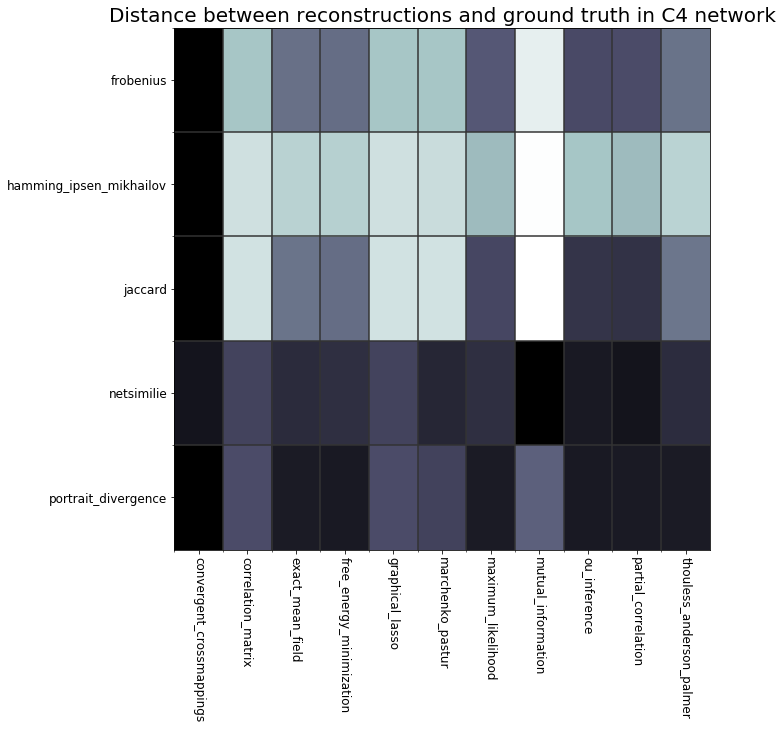

In [10]:
print('Generating ' + net_type + '.png')
N_reconstructors = len(reconstruction_methods)
N_distances = len(distance_methods_list)
mat = results
#### plotting parameters ####
netrd_cmap = 'bone_r'
width = 1.2
heigh = 1.2
mult  = 8.0

###### plot the mat ###########
fig, ax0 = plt.subplots(1, 1, figsize=(width*mult,heigh*mult))

ax0.imshow(mat, aspect='auto', cmap=netrd_cmap)

###### be obsessive about it ###########
ax0.set_xticks(np.arange(0, N_reconstructors, 1))
ax0.set_yticks(np.arange(0, N_distances, 1))
# ax0.set_xticklabels(np.arange(0, N_methods, 1), fontsize=2.0*mult)
# ax0.set_yticklabels(np.arange(0, N_methods, 1), fontsize=2.0*mult)
ax0.set_xticklabels(reconstruction_methods, fontsize=1.5*mult, rotation=270)
ax0.set_yticklabels(distance_methods_list, fontsize=1.5*mult)
ax0.set_xticks(np.arange(-.5, N_reconstructors-0.5, 1), minor=True)
ax0.set_yticks(np.arange(-.5, N_distances-0.5, 1), minor=True)
ax0.grid(which='minor', color='#333333', linestyle='-', linewidth=1.5)

ax0.set_title("Distance between reconstructions and ground truth in " + net_type + " network", fontsize=2.5*mult)

plt.savefig(net_type + '.png', bbox_inches='tight', dpi=200)